
=== DATASET: FER2013 ===
Mean=[0.507876455783844, 0.507876455783844, 0.507876455783844], Std=[0.25019553303718567, 0.25019553303718567, 0.25019553303718567]

--- Experiment: baseline ---
Epoch 1/60 | Train Loss: 1.1336 Acc: 0.5703 | Val Loss: 0.9746 Acc: 0.6336 | F1: 0.6314 | 74.9s
Epoch 2/60 | Train Loss: 0.8543 Acc: 0.6864 | Val Loss: 0.9204 Acc: 0.6691 | F1: 0.6603 | 74.2s
Epoch 3/60 | Train Loss: 0.6829 Acc: 0.7483 | Val Loss: 0.9884 Acc: 0.6765 | F1: 0.6684 | 74.7s
Epoch 4/60 | Train Loss: 0.5120 Acc: 0.8157 | Val Loss: 1.0286 Acc: 0.6761 | F1: 0.6738 | 73.9s
Epoch 5/60 | Train Loss: 0.3717 Acc: 0.8653 | Val Loss: 1.1247 Acc: 0.6709 | F1: 0.6682 | 74.2s
Epoch 6/60 | Train Loss: 0.2777 Acc: 0.9026 | Val Loss: 1.3002 Acc: 0.6698 | F1: 0.6705 | 74.0s
Epoch 7/60 | Train Loss: 0.2132 Acc: 0.9247 | Val Loss: 1.3928 Acc: 0.6789 | F1: 0.6730 | 74.3s
Epoch 8/60 | Train Loss: 0.1748 Acc: 0.9395 | Val Loss: 1.5391 Acc: 0.6771 | F1: 0.6767 | 74.1s
Epoch 9/60 | Train Loss: 0.1507 Acc: 0.9483 

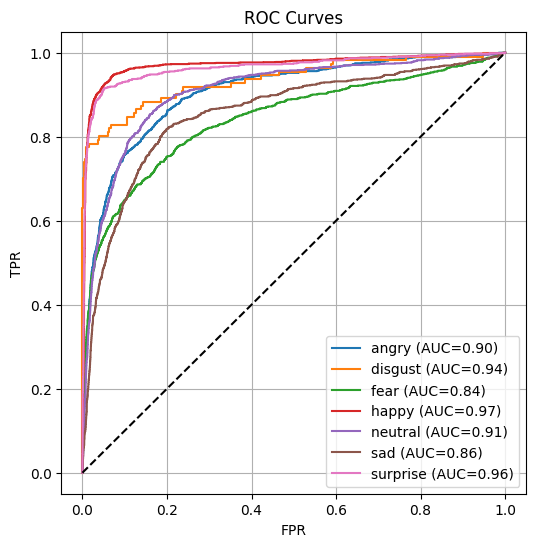

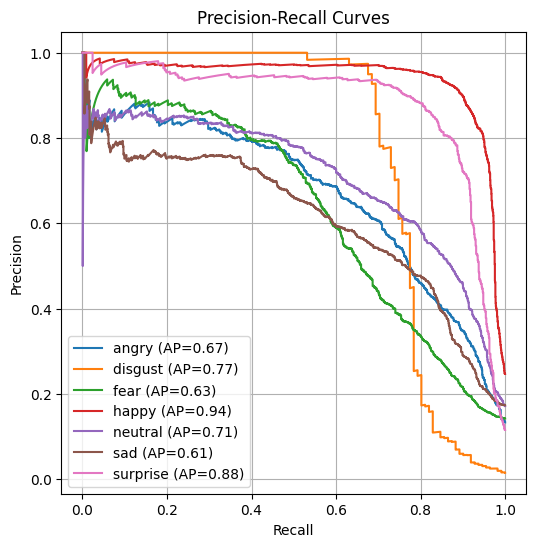

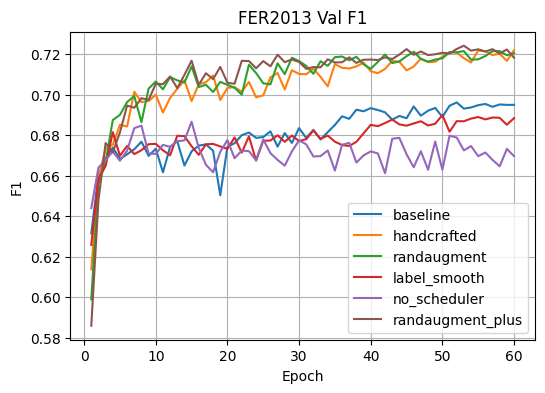

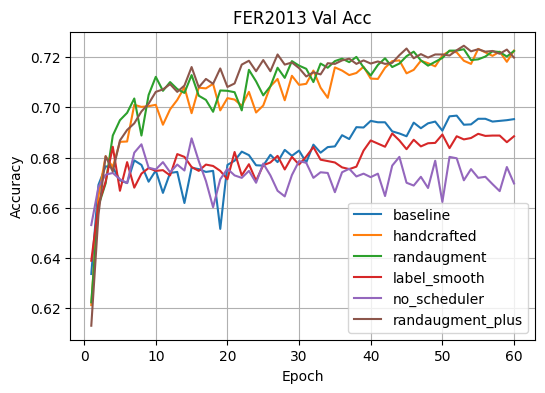

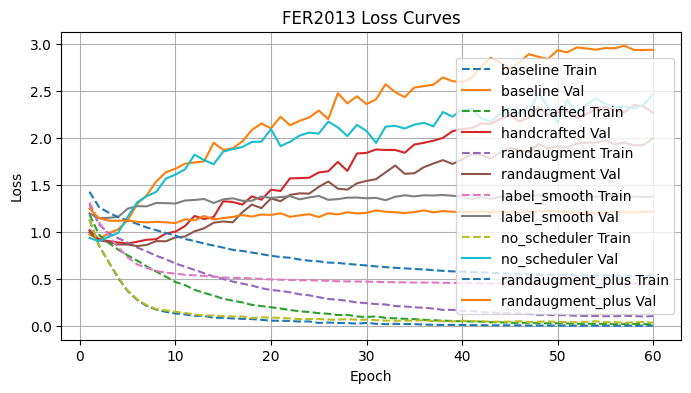

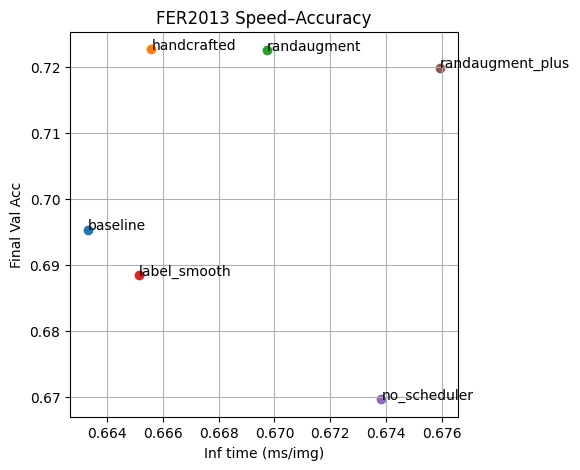


=== DATASET: FERPlus ===
Mean=[0.5077897310256958, 0.5077897310256958, 0.5077897310256958], Std=[0.2495584785938263, 0.2495584785938263, 0.2495584785938263]

--- Experiment: baseline ---
Epoch 1/60 | Train Loss: 0.7414 Acc: 0.7398 | Val Loss: 0.5661 Acc: 0.7956 | F1: 0.7871 | 74.7s
Epoch 2/60 | Train Loss: 0.4624 Acc: 0.8354 | Val Loss: 0.5431 Acc: 0.8227 | F1: 0.8126 | 73.8s
Epoch 3/60 | Train Loss: 0.3373 Acc: 0.8790 | Val Loss: 0.5544 Acc: 0.8134 | F1: 0.8125 | 74.1s
Epoch 4/60 | Train Loss: 0.2400 Acc: 0.9137 | Val Loss: 0.6178 Acc: 0.8184 | F1: 0.8171 | 73.9s
Epoch 5/60 | Train Loss: 0.1813 Acc: 0.9364 | Val Loss: 0.6596 Acc: 0.8246 | F1: 0.8228 | 74.3s
Epoch 6/60 | Train Loss: 0.1337 Acc: 0.9522 | Val Loss: 0.7533 Acc: 0.8129 | F1: 0.8127 | 74.1s
Epoch 7/60 | Train Loss: 0.1141 Acc: 0.9609 | Val Loss: 0.7928 Acc: 0.8255 | F1: 0.8222 | 74.4s
Epoch 8/60 | Train Loss: 0.0992 Acc: 0.9647 | Val Loss: 0.8917 Acc: 0.8265 | F1: 0.8253 | 74.1s
Epoch 9/60 | Train Loss: 0.1011 Acc: 0.9645 

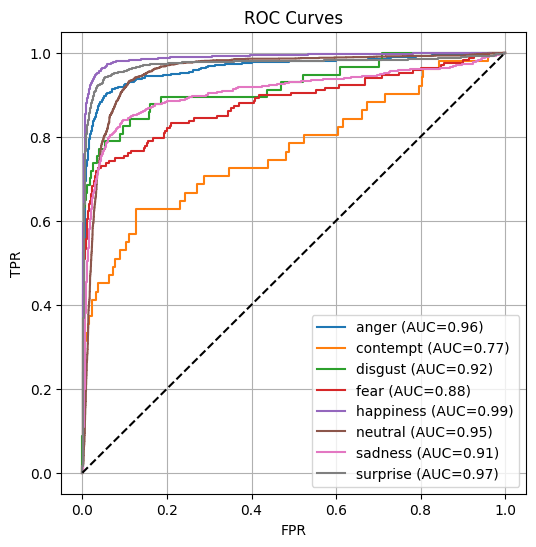

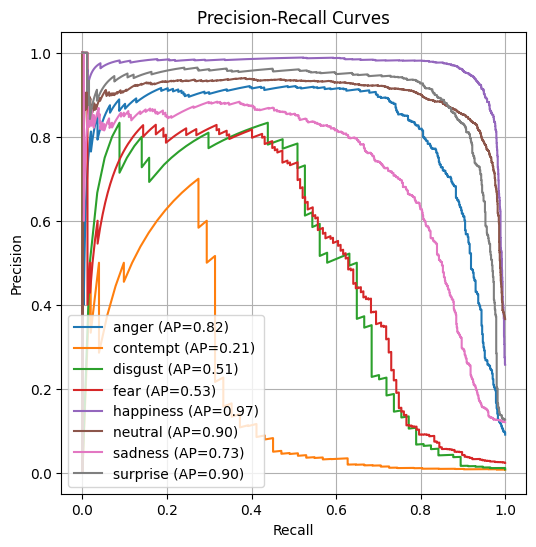

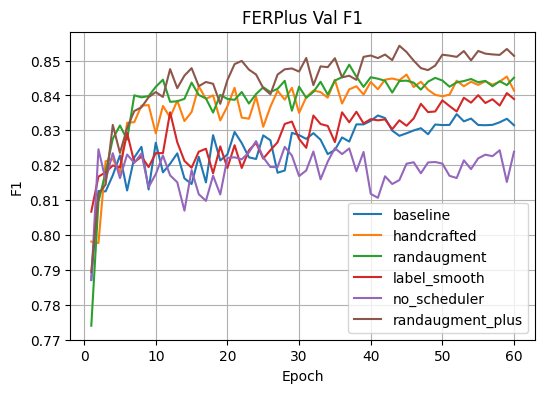

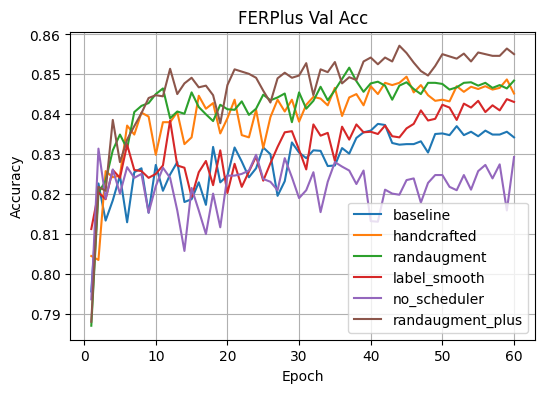

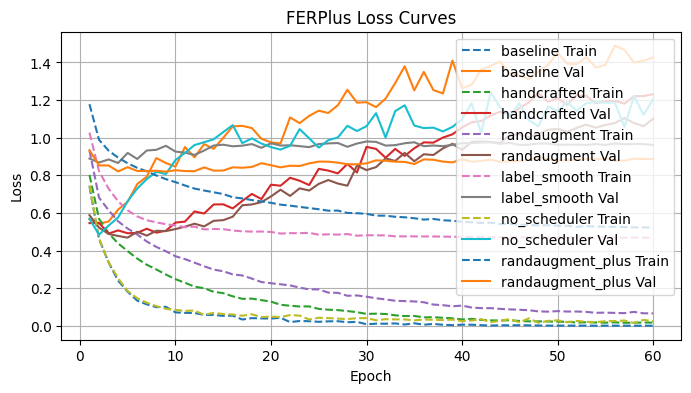

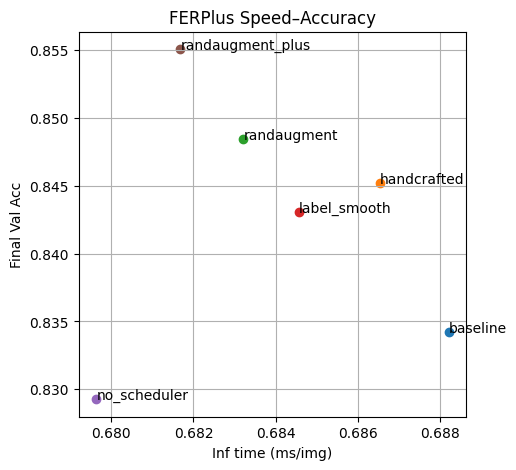

In [1]:
import os, copy, time, random
import numpy as np
import torch, torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import transforms, datasets, models
from torchvision.models import EfficientNet_B1_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve, average_precision_score

# 1) Config
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE  = 32
NUM_EPOCHS  = 60
LR          = 4e-4
WD          = 8e-4
IMG_SIZE    = 224
SMOOTH_eps  = 0.1
SEED        = 42

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# 2) Helpers
def calc_mean_std(root):
    tf = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                             transforms.Grayscale(3), transforms.ToTensor()])
    ds = datasets.ImageFolder(os.path.join(root,"train"), transform=tf)
    ld = DataLoader(ds, BATCH_SIZE, shuffle=False, num_workers=4)
    s, s2, n = torch.zeros(3), torch.zeros(3), 0
    for x,_ in ld:
        s  += x.sum([0,2,3])
        s2 += (x**2).sum([0,2,3])
        n  += x.numel()/3
    mean = s/n; std = (s2/n - mean**2).sqrt()
    return mean.tolist(), std.tolist()

def create_model(num_classes):
    m = models.efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
    in_f = m.classifier[1].in_features
    m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, num_classes))
    return m.to(DEVICE)

def make_dataloaders(root, train_tf, val_tf):
    tr = datasets.ImageFolder(os.path.join(root,"train"), transform=train_tf)
    va = datasets.ImageFolder(os.path.join(root,"test"),  transform=val_tf)
    return (
      DataLoader(tr, BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True),
      DataLoader(va, BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
      len(tr), len(va)
    )

# 3) train_one now computes train & val loss, acc, F1 and prints per-epoch with timing
def train_one(name, train_loader, val_loader, num_classes, cfg):
    model = create_model(num_classes)
    crit  = nn.CrossEntropyLoss(label_smoothing=cfg["smoothing"])
    opt   = optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    sched = (optim.lr_scheduler.CosineAnnealingLR(opt, T_max=NUM_EPOCHS)
             if cfg["scheduler"] else None)

    train_loss_hist, train_acc_hist = [], []
    val_loss_hist,   val_acc_hist   = [], []
    f1_hist = []

    for epoch in range(1, NUM_EPOCHS+1):
        t0 = time.time()
        # — Train —
        model.train()
        tot_loss, tot_corr, tot_samples = 0.0, 0, 0
        for x,y in train_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            out = model(x)
            loss = crit(out, y)
            loss.backward(); opt.step()

            preds = out.argmax(1)
            tot_corr   += (preds==y).sum().item()
            tot_samples+= y.size(0)
            tot_loss   += loss.item() * y.size(0)

        tr_loss = tot_loss / tot_samples
        tr_acc  = tot_corr / tot_samples
        train_loss_hist.append(tr_loss)
        train_acc_hist.append(tr_acc)

        if sched: sched.step()

        # — Val —
        model.eval()
        vt_loss, vt_corr, vt_samples = 0.0, 0, 0
        all_p, all_t = [], []
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(DEVICE), y.to(DEVICE)
                out = model(x)
                loss = crit(out, y)
                preds = out.argmax(1)

                vt_corr   += (preds==y).sum().item()
                vt_samples+= y.size(0)
                vt_loss    += loss.item() * y.size(0)
                all_p.extend(preds.cpu()); all_t.extend(y.cpu())

        v_loss = vt_loss / vt_samples
        v_acc  = vt_corr / vt_samples
        val_loss_hist.append(v_loss)
        val_acc_hist.append(v_acc)

        f1 = f1_score(all_t, all_p, average="weighted", zero_division=0)
        f1_hist.append(f1)

        elapsed = time.time() - t0
        print(f"Epoch {epoch}/{NUM_EPOCHS} | "
              f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | "
              f"Val Loss: {v_loss:.4f} Acc: {v_acc:.4f} | "
              f"F1: {f1:.4f} | {elapsed:.1f}s")

    # inference speed
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    t_inf = time.time()
    with torch.no_grad():
        for x,_ in val_loader:
            _ = model(x.to(DEVICE))
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    inf_time_ms = 1000 * (time.time() - t_inf) / len(val_loader.dataset)

    return (train_loss_hist, train_acc_hist,
            val_loss_hist, val_acc_hist,
            f1_hist, inf_time_ms, model)

# 4) ROC & PR for “randaugment_plus”
def plot_roc_pr(model, val_loader, class_names):
    model.eval()
    all_probs, all_true = [], []
    with torch.no_grad():
        for x,y in val_loader:
            x = x.to(DEVICE)
            logits = model(x)
            probs  = torch.softmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_true.append(y.numpy())
    P = np.vstack(all_probs); T = np.concatenate(all_true)
    n_cls = P.shape[1]

    # ROC
    plt.figure(figsize=(6,6))
    for i in range(n_cls):
        fpr, tpr, _ = roc_curve(T==i, P[:,i])
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={auc(fpr,tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.title("ROC Curves"); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend(loc="lower right"); plt.grid(); plt.show()

    # Precision-Recall
    plt.figure(figsize=(6,6))
    for i in range(n_cls):
        prec, rec, _ = precision_recall_curve(T==i, P[:,i])
        ap = average_precision_score(T==i, P[:,i])
        plt.plot(rec, prec, label=f"{class_names[i]} (AP={ap:.2f})")
    plt.title("Precision-Recall Curves"); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.legend(loc="lower left"); plt.grid(); plt.show()


# 5) Main
DATASETS = {
    "FER2013": "/home/roberh18/.cache/kagglehub/datasets/msambare/fer2013/versions/1",
    "FERPlus": "/home/roberh18/.cache/kagglehub/datasets/subhaditya/fer2013plus/versions/1/fer2013plus/fer2013"
}

for ds_name, ds_root in DATASETS.items():
    print(f"\n=== DATASET: {ds_name} ===")
    MEAN, STD = calc_mean_std(ds_root)
    print(f"Mean={MEAN}, Std={STD}")

    # transforms
    baseline_tf = transforms.Compose([
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.Grayscale(3), transforms.ToTensor(),
        transforms.Normalize(MEAN, STD),
    ])
    handcrafted_tf = transforms.Compose([
        transforms.Resize((IMG_SIZE+10,IMG_SIZE+10)),
        transforms.Grayscale(3), transforms.RandomCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(0.5), transforms.RandomRotation(15),
        transforms.RandomAffine(0,(0.1,0.1)), transforms.ToTensor(),
        transforms.Normalize(MEAN, STD),
        transforms.RandomErasing(p=0.3, scale=(0.02,0.1), ratio=(0.3,3.3)),
    ])
    randaugment_tf = transforms.Compose([
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.Grayscale(3),
        transforms.RandAugment(2,15),
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD),
        transforms.RandomErasing(p=0.5),
    ])
    val_tf = transforms.Compose([
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.Grayscale(3), transforms.ToTensor(),
        transforms.Normalize(MEAN, STD),
    ])

    # experiment setups
    experiment_cfgs = {
        "baseline":        {"tf": baseline_tf,    "smoothing": 0.0,       "scheduler": True},
        "handcrafted":     {"tf": handcrafted_tf, "smoothing": 0.0,       "scheduler": True},
        "randaugment":     {"tf": randaugment_tf, "smoothing": 0.0,       "scheduler": True},
        "label_smooth":    {"tf": baseline_tf,    "smoothing": SMOOTH_eps,"scheduler": True},
        "no_scheduler":    {"tf": baseline_tf,    "smoothing": 0.0,       "scheduler": False},
        "randaugment_plus":{"tf": randaugment_tf, "smoothing": SMOOTH_eps,"scheduler": True},
    }

    results, speeds = {}, {}
    class_names = None

    for name, cfg in experiment_cfgs.items():
        print(f"\n--- Experiment: {name} ---")
        tr_ld, va_ld, _, _ = make_dataloaders(ds_root, cfg["tf"], val_tf)
        class_names = tr_ld.dataset.classes
        (tr_l, tr_a, va_l, va_a, f1_h, spd, mdl) = train_one(name, tr_ld, va_ld, len(class_names), cfg)
        results[name] = (tr_l, tr_a, va_l, va_a, f1_h)
        speeds[name]  = spd
        if name == "randaugment_plus":
            print("\nPlotting ROC/PR for ‘randaugment_plus’…")
            plot_roc_pr(mdl, va_ld, class_names)

    epochs = range(1, NUM_EPOCHS+1)

    # a) F1
    plt.figure(figsize=(6,4))
    for n,(_,_,_,_,f1_h) in results.items():
        plt.plot(epochs, f1_h, label=n)
    plt.title(f"{ds_name} Val F1"); plt.xlabel("Epoch"); plt.ylabel("F1"); plt.legend(); plt.grid(); plt.show()

    # b) Accuracy
    plt.figure(figsize=(6,4))
    for n,(_,_,_,va_a,_) in results.items():
        plt.plot(epochs, va_a, label=n)
    plt.title(f"{ds_name} Val Acc"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(); plt.show()

    # c) Loss (train vs. val)
    plt.figure(figsize=(8,4))
    for n,(tr_l,_,va_l,_,_) in results.items():
        plt.plot(epochs, tr_l,  linestyle='--', label=f"{n} Train")
        plt.plot(epochs, va_l,  linestyle='-',  label=f"{n} Val")
    plt.title(f"{ds_name} Loss Curves"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.grid(); plt.show()

    # d) Speed vs. final accuracy
    plt.figure(figsize=(5,5))
    for n,spd in speeds.items():
        final_acc = results[n][3][-1]
        plt.scatter(spd, final_acc, label=n)
        plt.text(spd, final_acc, n)
    plt.xlabel("Inf time (ms/img)"); plt.ylabel("Final Val Acc")
    plt.title(f"{ds_name} Speed–Accuracy"); plt.grid(); plt.show()
